## Monte Carlo Methods and Non-standard Standard Errors with Bootstrapping

- Economists have sometimes been accused of "physics envy"
    - An overreliance on fancy math derivations and analytical solutions
- And old anecdote goes:
    - Once a competition was held to see who could solve a particular math problem the fastest
    - Physicists and economists were asked for their solutions
    - Economists spent weeks deriving an analytical solution
    - Physicists simply ran simulations on a computer 1,000,000 and got a correct, approximate answer in a few hours
- Monte Carlo methods provide a powerful alternative
- Monte Carlo methods embrace simulation
    - Instead of deriving an analytical solution, we simulate data from a known process
    - Then we estimate our model on the simulated data
    - Repeating this many times gives us an empirical distribution of estimates


## Why Simulation?

- Econometric problems are hard...
- Models become complex and analytical solutions may not be feasible
- The Analytical Limit: Standard econometric theory relies on asymptotic properties (e.g., $N \to \infty$).
- The Reality: We often work with finite samples, complex estimators, or clustered data where analytical variance formulas are intractable or unreliable.
- The Solution: Use computational power to approximate sampling distributions.
- Monte Carlo: We define the Data Generating Process (DGP).
- Bootstrap: We estimate the DGP from the data itself.

## Monte Carlo Methods

- A computational algorithm that relies on repeated random sampling to obtain numerical results.
- In Econometrics: We use MC to understand the properties of an estimator (unbiasedness, consistency, efficiency) because we control the truth.
- Example:
    - Verifying if an estimator works under specific violations (e.g., "How bad is OLS if errors are heteroskedastic?").
    - Power analysis for experimental design.
    - Testing new software packages or algorithms.
- Monte Carlo is a useful tool to have because it allows you to better understand the properties of estimators in complex settings.

## The Basic Loop for Monte Carlo

1. Define the DGP: Set parameters ($\beta$, $\sigma^2$) and distribution of error terms ($u \sim N(0,1)$).
2. Generate Data: Create independent variables ($X$) and calculate $Y = X\beta + u$.
3. Estimate: Run the model on this synthetic data and store the statistic of interest (e.g., $\hat{\beta}$).
4. Repeat: Loop $R$ times (e.g., $R=1000$).
5. Analyze: Plot the distribution of the $R$ stored estimates.

Does the mean of $\hat{\beta}$ equal the true $\beta$?  This is a question can answer because you KNOW the true $\beta$ in your DGP!

## But before that...

- How do we run regressions in Python?
- There are many packages, but we will use `statsmodels`.
- Statsmodels provides two ways of running OLS:
    - The formula API (similar to R's `lm()` function).
    - The object-oriented API (more flexible for programming).
- The steps for running a regression using the object-oriented API are:
    1. Import the package: `import statsmodels.api as sm`
    2. Prepare your data: Ensure your independent variables include a constant term if needed.
    3. Create the model: `model = sm.OLS(y, X)`
    4. Fit the model: `results = model.fit()`
    5. Access results: Use `results.params`, `results.bse`, `results.conf_int()`, etc.
- To adjust standard errors for heteroskedasticity, use:
    - `model_het = model.get_robustcov_results(cov_type='HC1')`
    - or:
        - `results_het = model.fit(cov_type='HC1')`

## The Meat of Monte Carlo

- I'm about to show you a simple regression model where I know the true parameters.
- Then I generate data from that model, estimate it, and store the results.
- This is basically the meat of any Monte Carlo simulation.
    - You create the DGP with random data and then you estimate it.
    


In [1]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np

X = np.random.normal(0, 1, 100)
u = np.random.normal(0, 1, 100)
y = 10 + 2 * X + u  # True beta is 2, intercept is 1

# Why is it okay to just write 1 here?

model = sm.OLS(y, X).fit()
# Why is this wrong?
# we need to add a constant to X
# X = sm.add_constant(X)
# model = sm.OLS(y, X).fit()

print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.010
Model:                            OLS   Adj. R-squared (uncentered):             -0.000
Method:                 Least Squares   F-statistic:                             0.9617
Date:                Fri, 23 Jan 2026   Prob (F-statistic):                       0.329
Time:                        11:22:32   Log-Likelihood:                         -370.50
No. Observations:                 100   AIC:                                      743.0
Df Residuals:                      99   BIC:                                      745.6
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [2]:
# Now with the formula API

data = {"y": y, "X": X}
model_formula = smf.ols("y ~ X", data=data).fit()
# constant is automatically added in formula API

print(model_formula.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     426.5
Date:                Fri, 23 Jan 2026   Prob (F-statistic):           1.79e-37
Time:                        11:22:32   Log-Likelihood:                -135.33
No. Observations:                 100   AIC:                             274.7
Df Residuals:                      98   BIC:                             279.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.8419      0.095    103.504      0.0

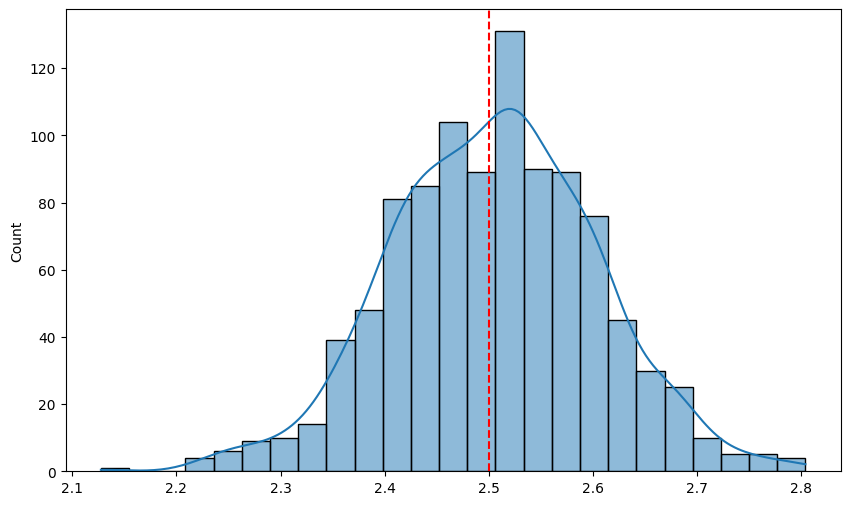

In [3]:
# A Simple Example

import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Define DGP
beta_true = 2.5
n_samples = 100
R = 1000

results = {"beta": [], "se": [], "ci": []}

for _ in range(R):
    # 2. Generate Data
    x = np.random.normal(0, 1, n_samples)
    u = np.random.normal(0, 1, n_samples)
    y = beta_true * x + u

    # 3. Estimate
    model = sm.OLS(y, x).fit()
    results["beta"].append(model.params[0])
    results["se"].append(model.bse[0])
    results["ci"].append(model.conf_int(alpha=0.05))


fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(results["beta"], kde=True, ax=ax)
ax.axvline(beta_true, color="red", linestyle="--", label="True β")

## Standard Errors

- Monte Carlo methods give us estimates of the sampling distribution of an estimator.
- You can see from above that the standard deviation of the estimates across simulations provides an empirical standard error.
- Does this align with the theoretical standard error derived analytically?
- What about confidence intervals?
- The confidence interval can be constructed from the empirical distribution of estimates.
- This is particularly useful when the theoretical distribution is unknown or complex.
- Just use the percentiles of the empirical distribution to form confidence intervals.
    - For 95% CI, use the 2.5th and 97.5th percentiles of the estimates.

In [4]:
print("Standard Deviation of betas:", np.std(results["beta"]))
print("Average Standard Error:", np.mean(results["se"]))

print(
    "2.5 and 97.5 percentiles of estimates:",
    np.percentile(results["beta"], [2.5, 97.5]),
)
print("Average Confidence Interval:", np.mean(results["ci"], axis=0))


Standard Deviation of betas: 0.0986124171917373
Average Standard Error: 0.10073571605148887
2.5 and 97.5 percentiles of estimates: [2.31061014 2.69339451]
Average Confidence Interval: [[2.30495923 2.70472226]]


- This is a powerful result, because it gives us an equivalence that we can use to understand estimators.
- There is direct link between looping through simulations and using the resulting distribution, and the analytical formulas for standard errors and confidence intervals.

## Verifying the Need for Heteroskedasticity-Robust SEs

- Let's say we suspect heteroskedasticity in our data.
- We can use Monte Carlo to see how OLS SEs perform under heteroskedasticity.
- Define a DGP with heteroskedastic errors (e.g., $Var(u|X) = \sigma^2 X^2$).
- Run OLS on simulated data and compare standard errors:
    - Regular OLS SEs vs. Heteroskedasticity-Robust SEs.
- Analyze the coverage of confidence intervals constructed using both SEs.

- Exercise: 
1. Adapt the code above to implement this simulation.
2. Plot the resulting distribution
3. Compare the standard deviation of the estimates to the average standard error reported by OLS.


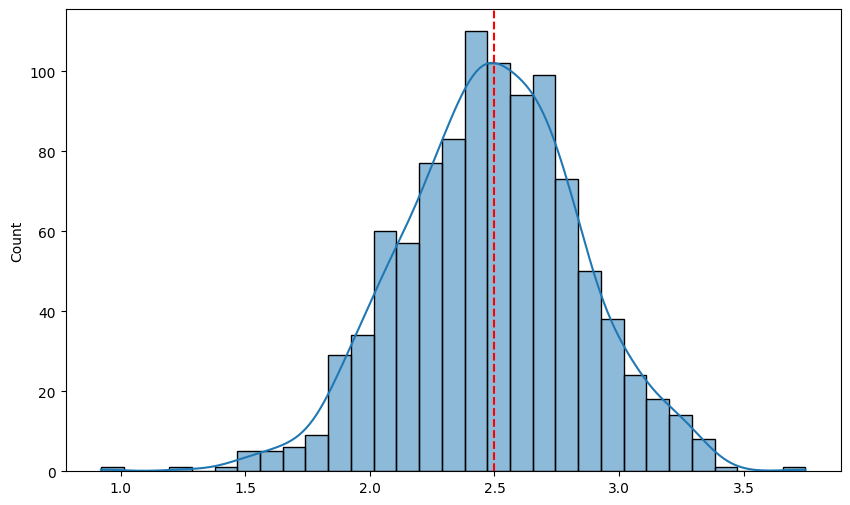

In [5]:
# A Simple Example

import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Define DGP
beta_true = 2.5
n_samples = 100
R = 1000

results = {"beta": [], "se": [], "ci": [], "se_het": [], "ci_het": []}

for _ in range(R):
    # 2. Generate Data
    x = np.random.normal(0, 1, n_samples)
    u = np.random.normal(0, x**2, n_samples)
    y = beta_true * x + u

    # 3. Estimate
    model = sm.OLS(y, x).fit()

    # 4. Estimate with robust SEs
    model_het = model.get_robustcov_results(cov_type="HC1")

    results["beta"].append(model.params[0])
    results["se"].append(model.bse[0])
    results["ci"].append(model.conf_int(alpha=0.05))
    results["se_het"].append(model_het.bse[0])
    results["ci_het"].append(model_het.conf_int(alpha=0.05))


fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(results["beta"], kde=True, ax=ax)
ax.axvline(beta_true, color="red", linestyle="--", label="True β")

In [6]:
print("Standard Deviation of betas:", np.std(results["beta"]))
print("Average Homoskedastic Standard Error:", np.mean(results["se"]))
print("-" * 40)
## They're off!
print(
    "2.5 and 97.5 percentiles of estimates:",
    np.percentile(results["beta"], [2.5, 97.5]),
)
print("Average Homoskedastic Confidence Interval:", np.mean(results["ci"], axis=0))
print("-" * 40)

print("Average Heteroskedasticity-Robust Standard Error:", np.mean(results["se_het"]))
print(
    "Average Heteroskedasticity-Robust Confidence Interval:",
    np.mean(results["ci_het"], axis=0),
)

Standard Deviation of betas: 0.35562511247403616
Average Homoskedastic Standard Error: 0.16100677780684694
----------------------------------------
2.5 and 97.5 percentiles of estimates: [1.78819457 3.19022934]
Average Homoskedastic Confidence Interval: [[2.16657089 2.80551564]]
----------------------------------------
Average Heteroskedasticity-Robust Standard Error: 0.3269864055407658
Average Heteroskedasticity-Robust Confidence Interval: [[1.8372313  3.13485523]]


- The standard errors were way too small because of heteroskedasticity.
- But the heteroskedasticity-robust standard errors were much closer to the true standard deviation of the estimates.
- A standard way to diagnose a problem with standard errors and confidence intervals is to look at coverage
- A 95% confidence interval should contain the true parameter 95% of the time. It should "cover" the true parameter 95% of the time.
- If the coverage is significantly lower than 95%, it indicates that the standard errors are underestimated, leading to overly narrow confidence intervals.
- Let's calculate the coverage for the above example

In [7]:
# calculate coverage probability

for ci in results["ci"]:
    # print(ci[0])
    coverage_hom = np.mean([
        (ci[0][0] <= beta_true <= ci[0][1]) for ci in results["ci"]
    ])
    coverage_het = np.mean([
        (ci[0][0] <= beta_true <= ci[0][1]) for ci in results["ci_het"]
    ])

print("Coverage Probability (Homoskedastic):", coverage_hom)
print("Coverage Probability (Heteroskedasticity-Robust):", coverage_het)

Coverage Probability (Homoskedastic): 0.62
Coverage Probability (Heteroskedasticity-Robust): 0.936


## Over- and Under- coverage

- If your confidence intervals contain the true parameter less than the nominal level (e.g., 95%), this is called "undercoverage."
    - Indicates that standard errors are underestimated.
    - Confidence intervals are too narrow.
- If your confidence intervals contain the true parameter more than the nominal level, this is called "overcoverage."
    - Indicates that standard errors are overestimated.
    - Confidence intervals are too wide.
- Monte Carlo simulations can help diagnose and correct these issues by allowing us to empirically assess the performance of our estimators and their associated standard errors.
- In the above example, we saw undercoverage with regular OLS SEs and proper coverage with heteroskedasticity-robust SEs.


## Monte Carlo and Power 

- Power is the probability of correctly rejecting a false null hypothesis (i.e., detecting an effect when there is one).

$$
Power = P(\text{Reject } H_0 | H_a \text{ is true})
$$

- We know that to calculate power in the case of a t-test in a regression, we need to know:
    - $\sigma^2_{\epsilon}$: The variance of the error term (residuals).
    - $n$: The total sample size.
    - $\sigma^2_{x_j}$: The variance of the independent variable (treatment) $X$.
    - $R^2_{x}$: The R-squared value from a regression of the independent variable $X$ on all other covariates in the model.
        - If $X$ is completely independent (e.g., a randomized controlled trial), $R^2_{x} \approx 0$.
        - The term $(1 - R^2_{x})$ represents the Variance Inflation Factor (VIF) tolerance; as $X$ becomes more correlated with other controls, the MDE increases (worsens).

- We can either find the MDE:

$$
MDE = \frac{\left(z_{1-\alpha / 2}+z_\beta\right) \sigma_\epsilon}{\sigma_{x_j} \sqrt{n\left(1-R^2\right)}}
$$

- or the minimum sample size needed to detect a given effect size:

$$
n = \frac{\left(z_{1-\alpha / 2}+z_\beta\right)^2 \sigma_{\epsilon}^2}{\sigma_{x_j}^2 \cdot MDE^2 \cdot\left(1-R^2\right)}
$$

## Aside: How do we increase power?

- Increase sample size ($n$)
- Decrease variance of errors ($\sigma^2_{\epsilon}$)
    - Improve measurement precision
    - Control for more covariates
- Increase variance of treatment ($\sigma^2_{x_j}$)
    - More variation in treatment assignment

- But what does this test assume:
    - Normality of errors
    - Homoskedasticity
    - Independence of observations
- What if these assumptions are violated?
- What if the model is more complex (e.g., clustered data, panel data)?
- What if the model is non-linear (e.g., logistic regression)?
- Monte Carlo methods allow us to empirically estimate power under more realistic conditions by simulating data.

## Monte Carlo Power Analysis

- Steps for Monte Carlo Power Analysis for the MDE
    - Preserve $X$: Since you have your regressors, you should treat $X$ as fixed. 
    - Estimate Noise Structure: Run a baseline regression on your current $y$ and $X$ to get the standard deviation of the residuals ($\hat{\sigma}_{\epsilon}$). 
    - Define the DGP: For each iteration, generate a synthetic outcome variable ($y_{sim}$).$y_{sim} = \beta_{test} \cdot X_1 + \epsilon
        - Where $\epsilon \sim N(0, \hat{\sigma}_{\epsilon})$.
        - Why don't you need to add the other regressors?
    - Grid Search: Loop through a list of increasing effect sizes ($\beta_{test}$). 
        - For each, run $N$ simulations, calculate the power (percentage of times $p < alpha$), and stop when Power $\approx 0.80$.
- Let's do this for a simple example

## Example

-  Suppose we want to know the minimum detectable effect for some regression coefficient in a linear model with homoskedastic errors.
- Let's compare the analytical MDE to the Monte Carlo MDE.

Simulating noise with std dev: 1.0206
Beta: 0.050 | Power: 0.36
Beta: 0.062 | Power: 0.47
Beta: 0.073 | Power: 0.57
Beta: 0.085 | Power: 0.74
Beta: 0.096 | Power: 0.82
Beta: 0.108 | Power: 0.92

Estimated MDE: 0.0929


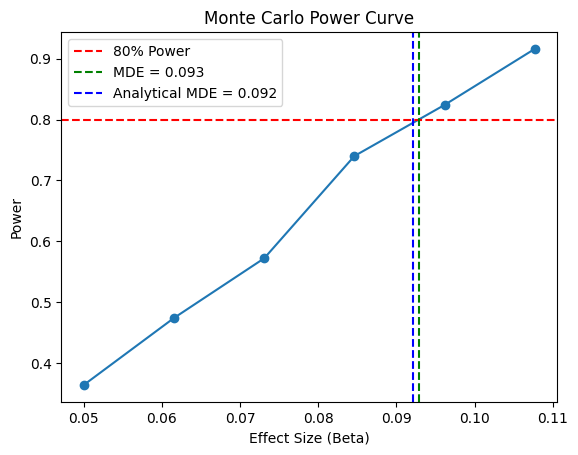

In [8]:
from scipy import stats

X = np.random.normal(size=(1000, 3))
y = X @ np.array([1.0, 0.5, -0.5]) + np.random.normal(size=1000)

# analytical mde
def reg_mde_analytical(X, y, idx=0, alpha=0.05, power=0.8):
    n, _ = X.shape
    t_alpha = stats.t.ppf(1 - alpha / 2, df=n - X.shape[1])
    t_power = stats.t.ppf(power, df=n - X.shape[1])
    reg = sm.OLS(y, X).fit()
    sigma_eps = reg.resid.std(ddof=1)

    # calculate R-squared of x on other regressors
    other_idx = [i for i in range(X.shape[1]) if i != idx]
    reg_x = sm.OLS(X[:, idx], X[:, other_idx]).fit()

    r2 = reg_x.rsquared
    sigma_x = np.std(X[:, idx], ddof=1)
    mde = ((t_alpha + t_power) * sigma_eps) / (sigma_x * np.sqrt(n * (1 - r2)))
    return mde


def reg_mde_mc(X, y, idx=0, target_power=0.8, alpha=0.05, n_sims=500, scan_range=(0.01, 1.0)):
    """
    Monte Carlo simulation to find the MDE for the first regressor in X.
    
    Parameters:
    - X: The design matrix (including constant and controls)
    - y: The observed outcome (used only to estimate noise scale)
    - scan_range: A tuple (min_beta, max_beta) to search across
    """
    
    # 1. Fit baseline model to get realistic noise levels
    baseline_model = sm.OLS(y, X).fit()
    resid_std = baseline_model.resid.std(ddof=1)
    
    # 2. Define the grid of effect sizes to test
    # We create a linearly spaced range of betas to test
    effect_sizes = np.linspace(scan_range[0], scan_range[1], 40)
    powers = []
    
    print(f"Simulating noise with std dev: {resid_std:.4f}")
    
    # 3. Grid Search Loop
    for beta in effect_sizes:
        significant_counts = 0
        
        for _ in range(n_sims):
            # Generate synthetic error terms based on real data's noise
            # We use the same N as the original data
            noise = np.random.normal(0, resid_std, size=len(y))
            
            # Construct y_sim. 
            # We inject the signal ONLY into the first variable of interest (X.iloc[:, 0])
            # We assume null effects for others to keep it clean, but we MUST include them
            # in the regression step to capture the VIF penalty.
            # Note: Ensure X contains a constant if your original model did.
            signal = beta * X[:, idx]
            y_sim = signal + noise
            
            # Run the model
            sim_model = sm.OLS(y_sim, X).fit()
            
            # Check if the p-value of the first regressor is significant
            # pvalues[0] corresponds to the first column in X
            if sim_model.pvalues[0] < alpha:
                significant_counts += 1
        
        # Calculate power for this specific beta
        current_power = significant_counts / n_sims
        powers.append(current_power)
        print(f"Beta: {beta:.3f} | Power: {current_power:.2f}")
        
        # Optimization: Stop early if we comfortably pass the target
        if current_power > target_power + 0.05:
            break

    # 4. Interpolate to find the exact MDE (crossing point at 0.8)
    try:
        mde = np.interp(target_power, powers, effect_sizes[:len(powers)])
        return mde, effect_sizes[:len(powers)], powers
    except ValueError:
        return None, effect_sizes, powers


# Run the MDE Search
mde, betas, powers = reg_mde_mc(X, y, scan_range=(0.05, 0.5))
mde_an = reg_mde_analytical(X, y)

print(f"\nEstimated MDE: {mde:.4f}")

# Visualization
plt.plot(betas, powers, marker='o')
plt.axhline(0.8, color='r', linestyle='--', label='80% Power')
plt.axvline(mde, color='g', linestyle='--', label=f'MDE = {mde:.3f}')
plt.axvline(mde_an, color='b', linestyle='--', label=f'Analytical MDE = {mde_an:.3f}')
plt.xlabel('Effect Size (Beta)')
plt.ylabel('Power')
plt.legend()
plt.title('Monte Carlo Power Curve')
plt.show()

## What does the loop do?

```
...
        for...
            # Check if the p-value of the first regressor is significant
            # pvalues[0] corresponds to the first column in X
            if sim_model.pvalues[0] < alpha:
                significant_counts += 1
        
        # Calculate power for this specific beta
        current_power = significant_counts / n_sims
        powers.append(current_power)
        print(f"Beta: {beta:.3f} | Power: {current_power:.2f}")
```

- counts how many times the p-value for the first regressor is less than the significance level (alpha) across all simulations for a given effect size
- Then it calculates the empirical power as the proportion of simulations where the null hypothesis is rejected (i.e., p-value < alpha) for that effect size.
- If the assumed coefficient is too small, then it is less likely to be statistically significant across simulations, resulting in lower power.
- As the effect size increases, the power should also increase, reflecting a higher likelihood of detecting the effect.

## Calculating minimum sample size for a given MDE

- Now let's do it for minimum sample size calculation

$$
n = \frac{\left(z_{1-\alpha / 2}+z_\beta\right)^2 \sigma_{\epsilon}^2}{\sigma_{x_j}^2 \cdot MDE^2 \cdot\left(1-R^2\right)}
$$



Simulating noise with std dev: 1.0206
N: 100 | Power: 0.16
N: 200 | Power: 0.25
N: 300 | Power: 0.39
N: 400 | Power: 0.47
N: 500 | Power: 0.59
N: 600 | Power: 0.68
N: 700 | Power: 0.72
N: 800 | Power: 0.78
N: 900 | Power: 0.84
N: 1000 | Power: 0.85
N: 1100 | Power: 0.89

Estimated Sample Size: 830.0


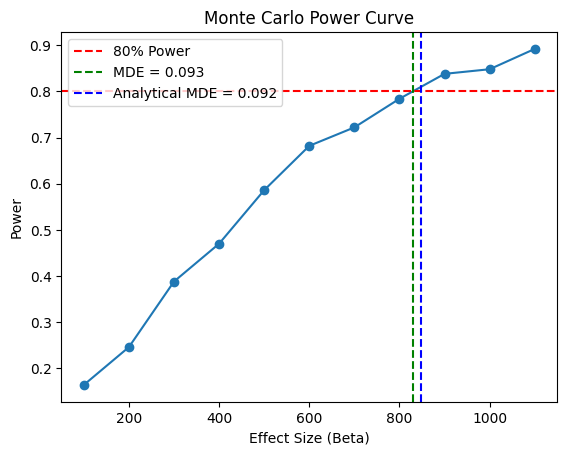

In [9]:
# analytical mde
def reg_n_analytical(X, y, mde, idx=0, alpha=0.05, power=0.8):
    n, _ = X.shape
    t_alpha = stats.t.ppf(1 - alpha / 2, df=n - X.shape[1])
    t_power = stats.t.ppf(power, df=n - X.shape[1])
    reg = sm.OLS(y, X).fit()
    var_eps = reg.resid.var(ddof=1)

    # calculate R-squared of x on other regressors
    other_idx = [i for i in range(X.shape[1]) if i != idx]
    reg_x = sm.OLS(X[:, idx], X[:, other_idx]).fit()

    r2 = reg_x.rsquared
    var_x = np.var(X[:, idx], ddof=1)
    mde = ((t_alpha + t_power) ** 2 * var_eps) / (var_x * (1 - r2) * mde**2)
    return mde


def reg_n_mc(
    X, y, mde, idx=0, target_power=0.8, alpha=0.05, n_sims=500, scan_range=(100, 2000)
):
    """
    Monte Carlo simulation to find the MDE for the first regressor in X.

    Parameters:
    - X: The design matrix (including constant and controls)
    - y: The observed outcome (used only to estimate noise scale)
    - scan_range: A tuple (min_beta, max_beta) to search across
    """

    # 1. Fit baseline model to get realistic noise levels
    baseline_model = sm.OLS(y, X).fit()
    resid_std = baseline_model.resid.std(ddof=1)

    # 2. Define the grid of effect sizes to test
    # We create a linearly spaced range of betas to test
    ns = np.arange(scan_range[0], scan_range[1], step=100)
    powers = []

    print(f"Simulating noise with std dev: {resid_std:.4f}")

    # 3. Grid Search Loop
    for n in ns:
        significant_counts = 0

        for _ in range(n_sims):
            # Generate synthetic error terms based on real data's noise
            # We use the same N as the original data
            noise = np.random.normal(0, resid_std, size=int(n))

            # Assume X is normal and construct X_sim
            X_sim = np.random.normal(X[:, idx].mean(), X[:, idx].std(), size=n)

            # Construct y_sim.
            # We inject the signal ONLY into the first variable of interest (X.iloc[:, 0])
            # We assume null effects for others to keep it clean, but we MUST include them
            # in the regression step to capture the VIF penalty.
            # Note: Ensure X contains a constant if your original model did.
            signal = mde * X_sim
            y_sim = signal + noise

            # Run the model
            sim_model = sm.OLS(y_sim, X_sim).fit()

            # Check if the p-value of the first regressor is significant
            # pvalues[0] corresponds to the first column in X
            if sim_model.pvalues[0] < alpha:
                significant_counts += 1

        # Calculate power for this specific beta
        current_power = significant_counts / n_sims
        powers.append(current_power)
        print(f"N: {np.ceil(n)} | Power: {current_power:.2f}")

        # Optimization: Stop early if we comfortably pass the target
        if current_power > target_power + 0.05:
            break

    # 4. Interpolate to find the exact MDE (crossing point at 0.8)
    try:
        n = np.interp(target_power, powers, ns[: len(powers)])
        return n, ns[: len(powers)], powers
    except ValueError:
        return None, ns, powers


# Run the MDE Search
n, betas, powers = reg_n_mc(X, y, mde=0.1)
n_an = reg_n_analytical(X, y, mde=0.1)

print(f"\nEstimated Sample Size: {np.ceil(n)}")

# Visualization
plt.plot(betas, powers, marker="o")
plt.axhline(0.8, color="r", linestyle="--", label="80% Power")
plt.axvline(n, color="g", linestyle="--", label=f"MDE = {mde:.3f}")
plt.axvline(n_an, color="b", linestyle="--", label=f"Analytical MDE = {mde_an:.3f}")
plt.xlabel("Effect Size (Beta)")
plt.ylabel("Power")
plt.legend()
plt.title("Monte Carlo Power Curve")
plt.show()

## No Data vs. Data

- A trick we used above was to create "semi-synthetic" data. It used real data for $X$ but simulated $y$ by adding noise and an assumed effect size.
- But you don't even need data for Monte Carlo!
- The beauty of Monte Carlo methods is that you don't need data!
- You can simulate everything from scratch based on assumed parameters and what you want to test.
    - What if your variable has measurement error? 
    - What if your errors are heteroskedastic?
    - Measurement error is a great example where analytical solutions can be complex, but Monte Carlo simulations can help you understand the impact on estimates and standard errors.


- There are two types of measurement errors: 
    - Classical Measurement Error: The observed variable is equal to the true variable plus some random noise 
        - So $X^* = X + Noise$ and $Noise$ isn't correlated to anything else.
        - This leads to *attenuation bias* where the estimated coefficient is biased towards zero.

Why? Suppose there is an $X$ but we only observe $X^* = X + e$, where $e$ is classical measurement error. 

When we run the regression of $Y$ on $X^*$, the estimated coefficient $\hat{\beta}$ is given by:

$$
\hat{\beta} = \frac{Cov(Y, X^*)}{Var(X^*)} 
$$

- Breaking this down further:
    - We know that since $e$ is classical measurement error, it is uncorrelated with both $Y$ and $X$. So:

$$
Cov(Y, X^*) = Cov(Y, X + e) = Cov(Y, X) + Cov(Y, e) = Cov(Y, X) \quad \text{(since } Cov(Y, e) = 0\text{)}
$$

But for the variance of $X^*$:

$$
Var(X^*) = Var(X + e) = Var(X) + Var(e) + 2Cov(X, e) = Var(X) + Var(e) \quad \text{(since } Cov(X, e) = 0\text{)}
$$

So our estimated coefficient becomes:

$$
\hat{\beta} = \frac{Cov(Y, X)}{Var(X) + Var(e)}
$$

Let $\lambda$ be the reliability ratio defined as:

$$
\lambda = \frac{Var(X)}{Var(X) + Var(e)}
$$

- Therefore, we can express the estimated coefficient as:

$$
\hat{\beta} = \lambda \cdot \frac{Cov(Y, X)}{Var(X)} = \lambda \cdot \beta
$$

$\lambda$ is between 0 and 1, so $\hat{\beta}$ is biased towards zero.

- Non-classical Measurement Error: The observed variable is equal to the true variable plus some bias that is correlated with the true variable or the error term in the regression.
    - This is really tough to handle analytically. The bias can go in any direction depending on the nature of the correlation.





## Classical and Non-classical Measurement Error

- For this example, I'm lazy and I don't want to keep making similar but slightly different functions.
- So I'm going to create a class that can generate the data for me with different types of measurement error.

## Example

- Suppose you want to see the effect stated income has on consumption
- Oftentimes income is misreported. Let's say we have two scenarios:
    - Classical measurement error: People randomly misreport their income (e.g., forget exact amount, round numbers).
    - Non-classical measurement error: People systematically underreport high incomes either to evade taxes or due to social desirability bias.
        - Social desirability bias occurs when respondents answer questions in a manner that will be viewed favorably by others.


In [75]:
class MeasurementErrorSimulator:
    def __init__(self, error_type, beta=None, n=None):
        self._catch_error_type(error_type)
        if beta is None:
            self.beta = np.ones(1)
        else:
            self.beta = beta

        if n is None:
            self.n = 1000
        else:
            self.n = n

    def _generate_true(self):

        X = np.random.normal(0, 1, (self.n, len(self.beta)))

        y = X @ self.beta + np.random.normal(0, 1, size=self.n)

        return X, y

    def _generate_classical(self, X):
        noise = np.random.normal(0, 1, size=self.n)
        X_measured = X.flatten() + noise
        return X_measured

    def _generate_systematic(self, X, threshold="median", effect=0.5):
        """Generates systematic bias in the variable, by having no effect below a threshold,
        but having an increasing effect above a threshold

        """
        if threshold == "median":
            thresh_value = np.median(X)
        else:
            thresh_value = threshold

        X_measured = np.where(X > thresh_value, effect * X, X)
        return X_measured

    def _catch_error_type(self, error_type):
        try:
            getattr(self, f"_generate_{error_type}")
            self.error_type = error_type
        except AttributeError:
            raise ValueError("Unsupported error type")

    def generate(self, *args, **kwargs):
        X, y = self._generate_true()
        X_measured = getattr(self, f"_generate_{self.error_type}")(X, *args, **kwargs)

        return pd.DataFrame({
            "X_true": X.flatten(),
            "X_measured": X_measured.flatten(),
            "y": y.flatten(),
        })


class MonteCarloVisualizer:
    def __init__(self, simulator, results=None):
        self.simulator = simulator
        self.results = results

    def simulate(self, n_sims=500, return_results=False, *args, **kwargs):
        results = {"beta_measured": []}

        for _ in range(n_sims):
            data = self.simulator.generate(*args, **kwargs)
            model_measured = sm.OLS(data["y"], data["X_measured"]).fit()

            results["beta_measured"].append(model_measured.params[0])

        print("Simulation complete.")
        self.results = results
        if return_results:
            return self.results
        return self

    def plot_results(self, results=None):
        if results is None:
            results = self.results
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.histplot(results["beta_measured"], kde=True, ax=ax)
        ax.axvline(self.simulator.beta[0], color="red", linestyle="--", label="True β")
        ax.set_title("Distribution of Estimated Betas with Measurement Error")
        ax.set_xlabel("Estimated Beta")
        ax.set_ylabel("Frequency")
        ax.legend()
        plt.show()

/var/folders/22/d2d1hrtn3kl9cq0gsx95c6lr0000gn/T/ipykernel_7485/4221874354.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results["beta_measured"].append(model_measured.params[0])


Simulation complete.


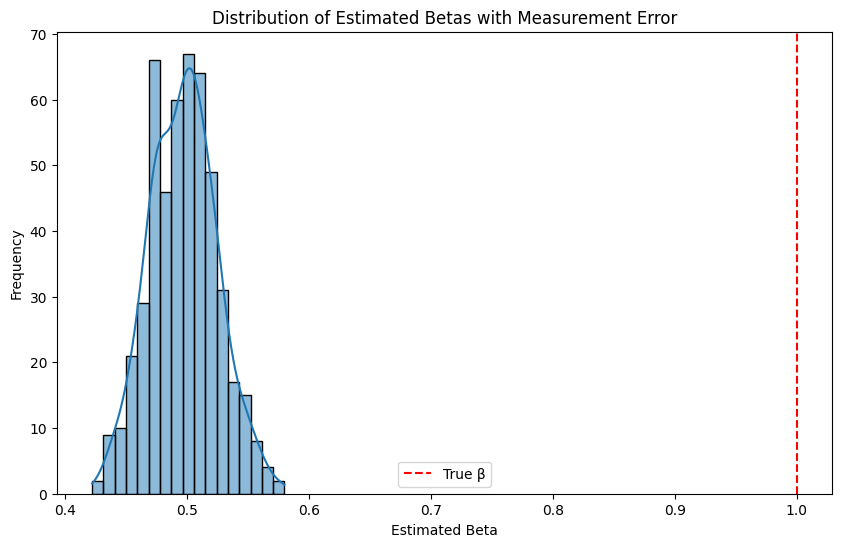

In [77]:
classical_simulator = MeasurementErrorSimulator(error_type="classical")

MonteCarloVisualizer(classical_simulator).simulate(500).plot_results()


/var/folders/22/d2d1hrtn3kl9cq0gsx95c6lr0000gn/T/ipykernel_7485/4221874354.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results["beta_measured"].append(model_measured.params[0])


Simulation complete.


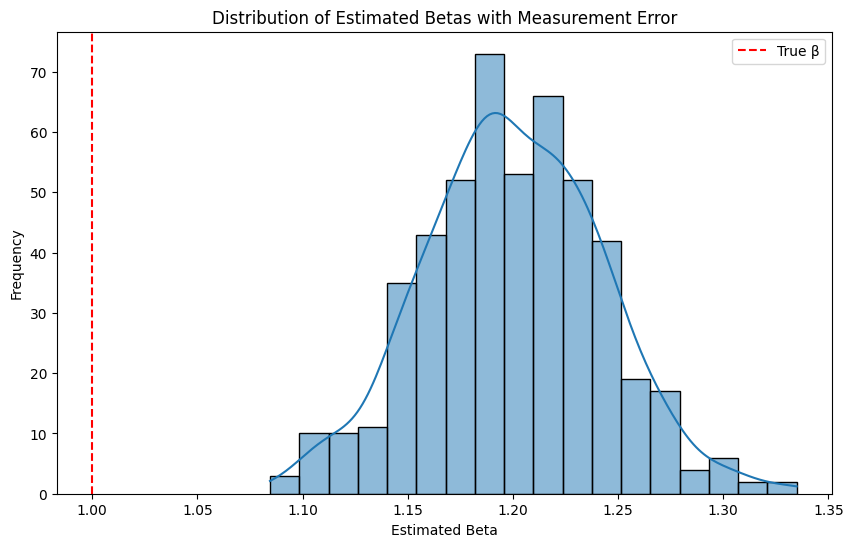

In [86]:
classical_simulator = MeasurementErrorSimulator(error_type="systematic")

MonteCarloVisualizer(classical_simulator).simulate(500, effect=0.5).plot_results()

## Conclusion

- There are many forms of non-classical measurement error: this is just one example.
- Monte Carlo methods provide a flexible way for you to understand the properties of estimators under complex scenarios.
- This is great, because you don't need to derive complex analytical solutions for biases or standard errors. 
- You can simply simulate it out and explore the data

---

## The Bootstrap vs. Monte Carlo

- Another data-drive/algorithmic method is the bootstrap
- The Core Insight: The Bootstrap **is** a Monte Carlo simulation.
- The algorithms for both are nearly identical (The Loop).
- They both use computational power to solve an intractable integral (the sampling distribution).
- The Difference is the Input (The Source of Truth):
    - Monte Carlo: We draw samples from a Theoretical Distribution ($F$) that we defined.
        - $X_{sim} \sim N(\mu, \sigma^2)$
    - Bootstrap: We draw samples from the Empirical Distribution ($\hat{F}$) observed in our data.
        - $X^*_{boot} \sim \text{Sample Data}$

Monte Carlo asks: "If the world worked exactly like this theory, what would the data look like?"

Bootstrap asks: "Given this data, what would other samples look like if the world is similar to my sample?"

## The Bootstrap Algorithm

Origin: Named after the fictional Baron Munchausen who pulled himself out of a swamp by his own hair (or bootstraps).

The Problem: We don't know the true DGP, so we cannot generate fresh samples from the population.

The Insight: The empirical distribution of the data is the best estimate we have of the population distribution.

Mechanism: Treat the sample as if it were the population and resample from it.

## The Bootstrap Algorithm

Resampling with Replacement
- Original Sample: Start with your dataset $D$ of size $N$.
- Resample: Draw $N$ observations from $D$ with replacement. This is $D^*_b$.
- Estimate: Calculate statistic $\hat{\theta}^*_b$ on $D^*_b$.
- Repeat: Loop $B$ times (e.g., $B=999$).
- Inference: Use the distribution of $\hat{\theta}^*$ to calculate standard errors or Confidence Intervals.$SE_{boot} = SD(\hat{\theta}^*)$

Why with replacement?

- To mimic the sampling variability present in the original data.

- There are many different types of bootstrapping methods, that attempt to account for different data structures (e.g., clustered data, time series data).
- In most cases, bootstrapping helps us get better standard errors and confidence intervals when analytical solutions are difficult or unreliable.

## The Boostrap in Practice

- We will consider four types of bootstrapping:
    - The Parametric Bootstrap
    - The Non-parametric/Pairs Bootstrap
    - The Wild Bootstrap

## The Parametric Bootstrap

- Similar to Monte Carlo: We assume a DGP and simulate data from it.
1. Estimate the model $y = X\beta + \epsilon$. 
2. Obtain $\hat{\beta}$ and $\hat{\sigma}^2$.
3. Impose a Distribution: Assume errors are Normal, $\epsilon \sim N(0, \hat{\sigma}^2)$.
4. Generate: Draw new errors $\epsilon^*$ from this theoretical distribution.
5. Construct: Create new outcome data: $y^* = X\hat{\beta} + \epsilon^*$.
- When to use: When you are confident in your structural assumptions (e.g., Maximum Likelihood Estimation).Trade-off: If your assumption (Normality) is wrong, your inference will be wrong. If it is right, this is more powerful than the non-parametric bootstrap.

```python
# A. Parametric (Naive Normal)
    sigma = np.std(resid)
    for _ in range(R_boot):
        y_boot = y_hat + np.random.normal(0, sigma, len(df))
        b_boot = sm.OLS(y_boot, sm.add_constant(df['x'])).fit().params['x']
        boot_res['Parametric'].append(b_boot)
```

## The Non-Parametric/Pairs Bootstrap

- Mechanism: Resample observations $(y_i, X_i)$ with replacement from the original dataset.
- Assumption: The empirical distribution function (EDF) of the sample is a consistent estimator of the population distribution function.
- Pros:
    - Robust to misspecification of the error distribution (e.g., doesn't assume Normality).
    - Handles complex nonlinearities automatically.
- Cons:
    - Can fail in small samples.
    - Inefficient if the true distribution is known (e.g., Normality).
- This is the standard bootstrap method used in economics.


```python
# Bootstrap Loop (Resampling Rows)
for i in range(1000):
    # A. Resample the DataFrame (Rows)
    # n=len(df), replace=True is the key
    df_boot = df.sample(n=len(df), replace=True)
    
    # B. Fit OLS on this "jumbled" dataset
    model_boot = sm.OLS(df_boot['y'], sm.add_constant(df_boot['x'])).fit()
    
    # C. Store
    params.append(model_boot.params['x'])
```

## Clustered Standard Errors

- Many datasets have a grouped or clustered structure (e.g., students within schools, employees within firms).
- Observations within the same cluster may be correlated, violating the independence assumption of standard OLS.
- Ignoring clustering can lead to underestimated standard errors and misleading inference.
- Clustered standard errors adjust for within-cluster correlation, providing more accurate standard error estimates.
- Usually, to account for clustered standard errors, we specify the cluster variable when fitting the model in `statsmodels`:
    - `results_clustered = model.fit(cov_type='cluster', cov_kwds={'groups': cluster_variable})`
- Clustered standard errors calculate the variance-covariance matrix of the estimator by aggregating the residuals at the cluster level, allowing for arbitrary correlation within clusters while assuming independence across clusters.

## Wild Cluster Bootsrap

The Problem: In clustered data, standard bootstrapping fails if the number of clusters ($G$) is small (e.g., < 30 states).
- Resampling whole states "with replacement" is too chunky; you might get the same state 5 times.
- The "Wild" Mechanism:
    - Do NOT resample data rows. Keep $X$ and $\hat{u}$ (residuals) fixed.
    - Perturb the residuals: Create new errors $u^*_g = \hat{u}_g \times v_g$.
    - $v_g$ is a random weight applied to all observations in cluster $g$.
    - The Weights ($v_g$): Usually Rademacher weights (+1 or -1 with probability 0.5).
    - This preserves the structure of the intra-cluster correlation while simulating randomness.

```python
for _ in range(R_boot):
        # 1. Assign random +1/-1 weight to each cluster
        weights = np.random.choice([-1, 1], size=len(clusters))
        weight_map = dict(zip(clusters, weights))
        v_g = df['cluster'].map(weight_map)
        
        # 2. Perturb y
        y_wild = y_hat + (resid * v_g)
        b_boot = sm.OLS(y_wild, sm.add_constant(df['x'])).fit().params['x']
        boot_res['Wild'].append(b_boot)
```

## Not on the Non-parametric Bootstrap for Clustering

- In the way I showed you, the non-parametric bootstrap is not valid for clustered data with few clusters.
- But with a modification, it can be made valid.
- If instead of resampling individual observations, you resample entire clusters (e.g., states) with replacement, you can preserve the intra-cluster correlation structure.
- This is called the "Cluster Bootstrap."


In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import (
    interact,
    interactive_output,
    IntSlider,
    Checkbox,
    ToggleButtons,
    Button,
    Layout,
    VBox,
    HBox,
    Label,
)


# -------------------------------------------------------------------------
# 1. The Data Generating Process (DGP)
# -------------------------------------------------------------------------
def generate_data(
    total_n, n_clusters, beta_true=1.5, is_hetero=False, is_clustered=False
):
    """
    Generates data where Total N is split across N Clusters.
    """
    # Calculate group size (approximate)
    n_per_cluster = int(total_n / n_clusters)
    remainder = total_n % n_clusters

    # Create Cluster IDs (distribute remainder)
    cluster_ids = np.repeat(np.arange(n_clusters), n_per_cluster)
    if remainder > 0:
        extra_ids = np.random.choice(n_clusters, remainder, replace=False)
        cluster_ids = np.concatenate([cluster_ids, extra_ids])

    real_n = len(cluster_ids)

    # 1. X: Correlated within cluster
    x_cluster_center = np.random.normal(0, 1, n_clusters)
    x = np.random.normal(x_cluster_center[cluster_ids], 0.5)

    # 2. Errors
    u = np.random.normal(0, 1.0, real_n)

    if is_hetero:
        u = u * (np.abs(x) + 0.5)

    if is_clustered:
        cluster_shock = np.random.normal(0, 2.0, n_clusters)
        u = u + cluster_shock[cluster_ids]

    y = 1 + beta_true * x + u

    return pd.DataFrame({"cluster": cluster_ids, "y": y, "x": x})


# -------------------------------------------------------------------------
# 2. The "God Mode" Simulator
# -------------------------------------------------------------------------
def get_true_distribution(total_n, n_clusters, is_hetero, is_clustered, R=400):
    betas = []
    for _ in range(R):
        df = generate_data(
            total_n, n_clusters, is_hetero=is_hetero, is_clustered=is_clustered
        )
        model = sm.OLS(df["y"], sm.add_constant(df["x"])).fit()
        betas.append(model.params["x"])
    return np.array(betas)


# -------------------------------------------------------------------------
# 3. The Bootstraps
# -------------------------------------------------------------------------
def run_bootstraps(df, pairs_mode="Simple", R_boot=200):
    model_ols = sm.OLS(df["y"], sm.add_constant(df["x"])).fit()
    y_hat = model_ols.fittedvalues
    resid = model_ols.resid

    boot_res = {"Parametric": [], "Pairs": [], "Wild": []}

    # A. Parametric
    sigma = np.std(resid)
    for _ in range(R_boot):
        y_boot = y_hat + np.random.normal(0, sigma, len(df))
        b_boot = sm.OLS(y_boot, sm.add_constant(df["x"])).fit().params["x"]
        boot_res["Parametric"].append(b_boot)

    # B. Pairs
    clusters = df["cluster"].unique()
    for _ in range(R_boot):
        if pairs_mode == "Simple (Rows)":
            df_boot = df.sample(n=len(df), replace=True)
        else:
            # Cluster-Block Resampling
            sampled_clusters = np.random.choice(
                clusters, size=len(clusters), replace=True
            )
            df_boot = pd.concat([df[df["cluster"] == c] for c in sampled_clusters])
        b_boot = sm.OLS(df_boot["y"], sm.add_constant(df_boot["x"])).fit().params["x"]
        boot_res["Pairs"].append(b_boot)

    # C. Wild
    for _ in range(R_boot):
        weights = np.random.choice([-1, 1], size=len(clusters))
        weight_map = dict(zip(clusters, weights))
        v_g = df["cluster"].map(weight_map)
        y_wild = y_hat + (resid * v_g)
        b_boot = sm.OLS(y_wild, sm.add_constant(df["x"])).fit().params["x"]
        boot_res["Wild"].append(b_boot)

    return boot_res


# -------------------------------------------------------------------------
# 4. Interactive Widget Logic
# -------------------------------------------------------------------------
def update_plot(
    total_n,
    n_clusters,
    is_hetero,
    is_clustered,
    pairs_mode,
    show_parametric,
    show_pairs,
    show_wild,
    rerun_trigger,
):

    # Validation
    if n_clusters > total_n:
        print(
            f"⛔ ERROR: Clusters ({n_clusters}) cannot exceed Sample Size ({total_n})."
        )
        return

    # Status Message
    avg_size = total_n / n_clusters
    print(f"🔄 Simulating... [N={total_n}, G={n_clusters}, Avg Size={avg_size:.1f}]")
    if not is_clustered:
        print("⚠️ NOTE: Clustering is OFF (Errors are i.i.d).")

    # 1. Truth
    true_betas = get_true_distribution(
        total_n, n_clusters, is_hetero, is_clustered, R=400
    )
    true_ci = np.percentile(true_betas, [2.5, 97.5])

    # 2. Sample
    df_observed = generate_data(
        total_n, n_clusters, is_hetero=is_hetero, is_clustered=is_clustered
    )

    # 3. Bootstraps
    boots = run_bootstraps(df_observed, pairs_mode=pairs_mode, R_boot=200)

    # 4. Plot
    plt.figure(figsize=(14, 7))

    # Plot Truth (Grey)
    sns.kdeplot(
        true_betas,
        color="grey",
        fill=True,
        alpha=0.2,
        linewidth=0,
        label="TRUE Sampling Dist",
    )
    plt.axvline(true_ci[0], color="grey", linestyle="-", linewidth=3, alpha=0.4)
    plt.axvline(
        true_ci[1],
        color="grey",
        linestyle="-",
        linewidth=3,
        alpha=0.4,
        label="True 95% CI",
    )

    colors = {"Parametric": "red", "Pairs": "blue", "Wild": "green"}
    shift_target = np.mean(true_betas)

    methods_to_plot = []
    if show_parametric:
        methods_to_plot.append("Parametric")
    if show_pairs:
        methods_to_plot.append("Pairs")
    if show_wild:
        methods_to_plot.append("Wild")

    for name in methods_to_plot:
        res = boots[name]
        centered_res = np.array(res) - np.mean(res) + shift_target
        ci_method = np.percentile(centered_res, [2.5, 97.5])
        label = f"{name} ({pairs_mode})" if name == "Pairs" else name

        sns.kdeplot(centered_res, color=colors[name], linewidth=2, label=label)
        plt.axvline(ci_method[0], color=colors[name], linestyle="--", linewidth=1.5)
        plt.axvline(ci_method[1], color=colors[name], linestyle="--", linewidth=1.5)

    plt.title(f"Bootstrap Comparison", fontsize=15)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.2)
    plt.show()


# -------------------------------------------------------------------------
# 5. UI Layout
# -------------------------------------------------------------------------
box_layout = Layout(display="flex", flex_flow="row", justify_content="space-between")

# Controls
chk_hetero = Checkbox(value=False, description="Heteroskedasticity")
chk_cluster = Checkbox(value=True, description="Clustering")
chk_para = Checkbox(value=True, description="Show Parametric")
chk_pairs = Checkbox(value=True, description="Show Pairs")
chk_wild = Checkbox(value=True, description="Show Wild")
toggle_pairs = ToggleButtons(
    options=["Simple (Rows)", "Cluster (Blocks)"], description="Pairs Type:"
)
slider_total_n = IntSlider(min=50, max=1000, step=50, value=300, description="Total N")
slider_clusters = IntSlider(
    min=5, max=100, step=5, value=10, description="Clusters (G)"
)

# The Rerun Button Logic
btn_rerun = Button(description="Rerun Simulation", icon="refresh", button_style="info")
# We use a hidden slider to act as a trigger for the interactive_output
rerun_trigger = IntSlider(value=0, layout=Layout(display="none"))


def on_rerun_click(b):
    rerun_trigger.value += 1  # Changing this value forces the plot to update


btn_rerun.on_click(on_rerun_click)

# Assemble UI
ui = VBox([
    HBox([btn_rerun]),
    HBox([Label("Scenario:"), chk_hetero, chk_cluster], layout=box_layout),
    HBox([Label("Show Methods:"), chk_para, chk_pairs, chk_wild], layout=box_layout),
    toggle_pairs,
    HBox([slider_total_n, slider_clusters]),
])

# Link Logic to UI
out = interactive_output(
    update_plot,
    {
        "total_n": slider_total_n,
        "n_clusters": slider_clusters,
        "is_hetero": chk_hetero,
        "is_clustered": chk_cluster,
        "pairs_mode": toggle_pairs,
        "show_parametric": chk_para,
        "show_pairs": chk_pairs,
        "show_wild": chk_wild,
        "rerun_trigger": rerun_trigger,
    },
)

display(ui, out)

Output()